<a href="https://colab.research.google.com/github/vinayakr99/Muse-MotorImageryClassification/blob/main/MotorImagery_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [90]:
import tensorflow as tf
!pip install tensorflow-addons
!pip install mne
import tensorflow_addons as tfa
from tqdm.notebook import tqdm

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, SpatialDropout1D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.layers import Flatten, InputSpec, Layer, Concatenate, AveragePooling2D, MaxPooling2D, Reshape, Permute
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D, LayerNormalization
from tensorflow.keras.layers import TimeDistributed, Lambda, AveragePooling1D, Add, Conv1D, Multiply
from tensorflow.keras.constraints import max_norm, unit_norm 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.utils import plot_model

import random
import mne
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import silhouette_score, confusion_matrix

import pandas as pd
import numpy as np
from glob import glob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Model

**Parameters**

In [91]:
Fs = 256             # Sampling frequency
n_channels = 4       # Number of channels
Wn = 1               # Sampling window duration
n_samples = Wn*Fs    # sampling window length per channel

n_ff = [2,4,8,16]    # Number of frequency filters for each inception module of EEG-ITNet
n_sf = [1,1,1,1]     # Number of spatial filters in each frequency sub-band of EEG-ITNet
batch_size = 32 
epochs = 20

**Model architecture (EEG-ITNet)**

In [92]:
def Network(Chans, Samples, out_type = 'single'):
  out_class = 2
  Input_block = Input(shape = (Chans, Samples, 1))
  drop_rate = 0.2

  block1 = Conv2D(n_ff[0], (1, 16), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_1')(Input_block)
  block1 = BatchNormalization()(block1)
  block1 = DepthwiseConv2D((Chans, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[0], activation = 'linear', 
                           depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_1')(block1)
  block1 = BatchNormalization()(block1)
  block1 = Activation('elu')(block1)

  #================================

  block2 = Conv2D(n_ff[1], (1, 32), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_2')(Input_block)
  block2 = BatchNormalization()(block2)
  block2 = DepthwiseConv2D((Chans, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[1], activation = 'linear', 
                           depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_2')(block2)
  block2 = BatchNormalization()(block2)
  block2 = Activation('elu')(block2)

  #================================

  block3 = Conv2D(n_ff[2], (1, 64), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_3')(Input_block)
  block3 = BatchNormalization()(block3)
  block3 = DepthwiseConv2D((Chans, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[2], activation = 'linear', 
                           depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_3')(block3)
  block3 = BatchNormalization()(block3)
  block3 = Activation('elu')(block3)

  #================================

  block4 = Conv2D(n_ff[3], (1, 128), use_bias = False, activation = 'linear', padding='same', name = 'Spectral_filter_4')(Input_block)
  block4 = BatchNormalization()(block4)
  block4 = DepthwiseConv2D((Chans, 1), use_bias = False, padding='valid', depth_multiplier = n_sf[3], activation = 'linear', 
                           depthwise_constraint = tf.keras.constraints.MaxNorm(max_value=1), name = 'Spatial_filter_4')(block4)
  block4 = BatchNormalization()(block4)
  block4 = Activation('elu')(block4)

  #================================

  block = Concatenate(axis = -1)([block1, block2, block3, block4]) 

  #================================

  block = AveragePooling2D((1, 4))(block)
  block_in = Dropout(drop_rate)(block)

  #================================

  paddings = tf.constant([[0,0], [0,0], [3,0], [0,0]])
  block = tf.pad(block_in, paddings, "CONSTANT")
  block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = Dropout(drop_rate)(block)
  block = tf.pad(block, paddings, "CONSTANT")
  block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 1))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = Dropout(drop_rate)(block)
  block_out = Add()([block_in, block])


  paddings = tf.constant([[0,0], [0,0], [6,0], [0,0]])
  block = tf.pad(block_out, paddings, "CONSTANT")
  block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = Dropout(drop_rate)(block)
  block = tf.pad(block, paddings, "CONSTANT")
  block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 2))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = Dropout(drop_rate)(block)
  block_out = Add()([block_out, block])


  paddings = tf.constant([[0,0], [0,0], [12,0], [0,0]])
  block = tf.pad(block_out, paddings, "CONSTANT")
  block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = Dropout(drop_rate)(block)
  block = tf.pad(block, paddings, "CONSTANT")
  block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 4))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = Dropout(drop_rate)(block)
  block_out = Add()([block_out, block]) 


  paddings = tf.constant([[0,0], [0,0], [24,0], [0,0]])
  block = tf.pad(block_out, paddings, "CONSTANT")
  block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = Dropout(drop_rate)(block)
  block = tf.pad(block, paddings, "CONSTANT")
  block = DepthwiseConv2D((1,4), padding="valid", depth_multiplier=1, dilation_rate=(1, 8))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = Dropout(drop_rate)(block)
  block_out = Add()([block_out, block]) 

  #================================

  block = block_out

  #================================

  block = Conv2D(28, (1,1))(block)
  block = BatchNormalization()(block)
  block = Activation('elu')(block)
  block = AveragePooling2D((1,4), data_format='Channels_last')(block) #'Channels_last' As CPU will be used for inference
  block = Dropout(drop_rate)(block) 
  embedded = Flatten()(block)

  out = Dense(out_class, activation = 'softmax', kernel_constraint = max_norm(0.2))(embedded)

  return Model(inputs = Input_block, outputs = out)


# Data Preparation (Training)


In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load train recording CSV files as Pandas Dataframe with shape (Samples,Channels)**

In [94]:
files1 = glob('drive/MyDrive/MotorImagery/Train/*Left*')                                             #Training data (csv files) for 'Left' Imagery
files2 = glob('drive/MyDrive/MotorImagery/Train/*Right*')                                            #Training data (csv files) for 'Right' Imagery

data1 = pd.DataFrame()                                                                               #dataframe for 'Left' Imagery
data2 = pd.DataFrame()                                                                               #dataframe for 'Right' Imagery

for f in files1:
    #print(f) 
    df=pd.read_csv(f)
    cols_remove=df.columns.tolist()[:1]
    df=df.loc[:, ~df.columns.isin(cols_remove)]
    df.columns = df.columns.str.replace('RAW_',"",1)
    df = df.fillna(df.mean())                                                                        #Replacing null values with mean
    data1 = data1.append(df,ignore_index=True)

for f in files2:
    #print(f)
    df=pd.read_csv(f)
    cols_remove=df.columns.tolist()[:1]
    df=df.loc[:, ~df.columns.isin(cols_remove)]
    df.columns = df.columns.str.replace('RAW_',"",1)
    df = df.fillna(df.mean())                                      
    data2 = data2.append(df,ignore_index=True)






In [95]:
print(data1)                                                                                           #check

               TP9         AF7         AF8        TP10
0       798.205139  780.879150  779.267395  787.728943
1       801.831482  782.087891  784.505493  794.981689
2       804.652039  782.893799  782.893799  793.772888
3       805.860779  787.728943  782.893799  794.981689
4       799.010986  788.937744  784.505493  797.399292
...            ...         ...         ...         ...
143014  795.787537  795.787537  799.010986  788.131897
143015  794.578735  801.428589  799.010986  796.996338
143016  785.714294  797.399292  795.384644  792.564087
143017  783.699646  799.010986  792.967041  783.296692
143018  790.549438  799.010986  794.175842  785.714294

[143019 rows x 4 columns]


**MNE Epochs Function**

In [96]:
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=256)
    info.set_montage('standard_1020')
    data=mne.io.RawArray(sub.T, info)
    data.set_eeg_reference()
    epochs=mne.make_fixed_length_epochs(data,duration=Wn,overlap=0.2*Wn)
    return epochs.get_data()

**Convert to MNE epochs, load as numpy arrays and create labels**

In [97]:
x_left = np.empty((0, n_channels, n_samples))
y_left = np.empty(0)
x_right = np.empty((0, n_channels, n_samples))
y_right = np.empty(0)

data = convertDF2MNE(data1)
for i in enumerate(data):
  label=0
  y_left=np.append(y_left,label)
x_left = np.append(x_left,data,axis=0)

data = convertDF2MNE(data2)
for i in enumerate(data):
  label=1
  y_right=np.append(y_right,label)
x_right = np.append(x_right,data,axis=0)





Creating RawArray with float64 data, n_channels=4, n_times=143019
    Range : 0 ... 143018 =      0.000 ...   558.664 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
698 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 698 events and 256 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=4, n_times=137873
    Range : 0 ... 137872 =      0.000 ...   538.562 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 672 events and 256 original time points ...
0 bad epochs dropped


**Train, Validation Split**

In [98]:
x_left = x_left[:,:,:,np.newaxis]
x_right = x_right[:,:,:,np.newaxis]
split = 64

x_train = np.concatenate((x_left[split:,:,:,:],x_right[split:,:,:,:]), axis=0)
x_val = np.concatenate((x_left[:split,:,:,:],x_right[:split,:,:,:]), axis=0)

y_train = np.concatenate((y_left[split:],y_right[split:]))
y_val = np.concatenate((y_left[:split],y_right[:split]))

**Check for any 'NaN' values**

In [99]:
np.argwhere(np.isnan(x_train))


array([], shape=(0, 4), dtype=int64)

# Load Test Data

**Load test recording CSV files as pandas dataframe**

In [100]:
files1 = glob('drive/MyDrive/MotorImagery/Test/*Left*')                                                  #Test data for 'Left' Imagery
files2 = glob('drive/MyDrive/MotorImagery/Test/*Right*')                                                 #Test data for 'Right' Imagery

data1_test = pd.DataFrame()
data2_test = pd.DataFrame()

for f in files1:
    #print(f) 
    df=pd.read_csv(f)
    cols_remove=df.columns.tolist()[:1]
    df=df.loc[:, ~df.columns.isin(cols_remove)]
    df.columns = df.columns.str.replace('RAW_',"",1)
    df = df.fillna(df.mean())
    data1_test = data1_test.append(df,ignore_index=True)

for f in files2:
    #print(f)
    df=pd.read_csv(f)
    cols_remove=df.columns.tolist()[:1]
    df=df.loc[:, ~df.columns.isin(cols_remove)]
    df.columns = df.columns.str.replace('RAW_',"",1)
    df = df.fillna(df.mean())
    data2_test = data2_test.append(df,ignore_index=True)

**Convert to MNE Epochs and load as numpy arrays with labels**

In [101]:
x_test = np.empty((0, n_channels, n_samples))
y_test = np.empty(0)

data = convertDF2MNE(data1_test)
for i in enumerate(data):
  label=0
  y_test=np.append(y_test,label)
x_test = np.append(x_test,data,axis=0)

data = convertDF2MNE(data2_test)
for i in enumerate(data):
  label=1
  y_test=np.append(y_test,label)
x_test = np.append(x_test,data,axis=0)

x_test = x_test[:,:,:,np.newaxis]

Creating RawArray with float64 data, n_channels=4, n_times=10236
    Range : 0 ... 10235 =      0.000 ...    39.980 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 49 events and 256 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=4, n_times=10209
    Range : 0 ... 10208 =      0.000 ...    39.875 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 49 events and 256 original time points ...
0 bad epochs dropped


# Visualization (optional)

**Convert to MNE Epochs**

In [ ]:
test1 = convertDF2MNE(data1)
test2 = convertDF2MNE(data2)

 

Creating RawArray with float64 data, n_channels=4, n_times=143019
    Range : 0 ... 143018 =      0.000 ...   558.664 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
698 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 698 events and 256 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=4, n_times=137873
    Range : 0 ... 137872 =      0.000 ...   538.562 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 672 events and 256 original time points ...
0 bad epochs dropped


**Left,Right Comparison - TP9,TP10**

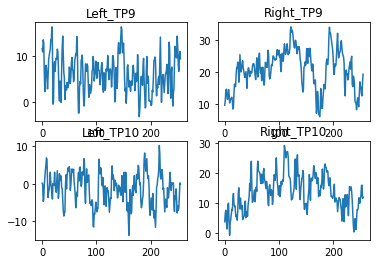

In [ ]:
x = np.arange(0, len(test1[0][0]))
y1 = test1[0][0]
y2 = test2[1][0]
y3 = test1[1][3]
y4 = test2[1][3]

figure, axis = plt.subplots(2, 2)
  
# For Channel 1
axis[0, 0].plot(x, y1)
axis[0, 0].set_title("Left_TP9")
  
# For Channel 2
axis[0, 1].plot(x, y2)
axis[0, 1].set_title("Right_TP9")

# For Channel 1
axis[1, 0].plot(x, y3)
axis[1, 0].set_title("Left_TP10")
  
# For Channel 2
axis[1, 1].plot(x, y4)
axis[1, 1].set_title("Right_TP10")
  
# Combine all the operations and display
plt.show()

**Left,Right Comparison - AF7,AF8**

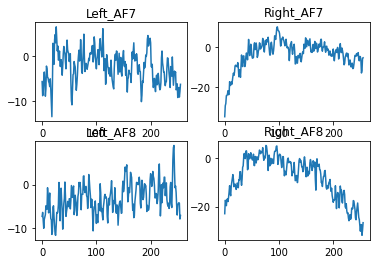

In [ ]:
x = np.arange(0, len(test1[1][0]))
y1 = test1[0][1]
y2 = test2[0][1]
y3 = test1[0][2]
y4 = test2[0][2]

figure, axis = plt.subplots(2, 2)
  
# For Channel 1
axis[0, 0].plot(x, y1)
axis[0, 0].set_title("Left_AF7")
  
# For Channel 2
axis[0, 1].plot(x, y2)
axis[0, 1].set_title("Right_AF7")

# For Channel 1
axis[1, 0].plot(x, y3)
axis[1, 0].set_title("Left_AF8")
  
# For Channel 2
axis[1, 1].plot(x, y4)
axis[1, 1].set_title("Right_AF8")
  
# Combine all the operations and display
plt.show()

**Train Data Visualization**

In [ ]:
print(x_train.shape)
print(y_train.shape)

(1242, 4, 256, 1)
(1242,)


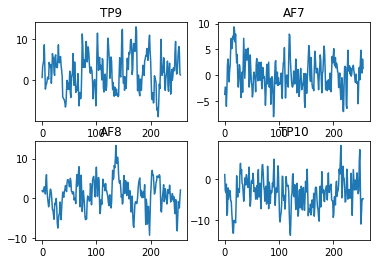

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to be plotted
x = np.arange(0, len(x_train[1][0]))
y1 = x_train[2][0]
y2 = x_train[2][1]
y3 = x_train[2][2]
y4 = x_train[2][3]

figure, axis = plt.subplots(2, 2)
  
# For Channel 1
axis[0, 0].plot(x, y1)
axis[0, 0].set_title("TP9")
  
# For Channel 2
axis[0, 1].plot(x, y2)
axis[0, 1].set_title("AF7")
  
# For Channel 3
axis[1, 0].plot(x, y3)
axis[1, 0].set_title("AF8")
  
# For Channel 4
axis[1, 1].plot(x, y4)
axis[1, 1].set_title("TP10")
  
# Combine all the operations and display
plt.show()

# Training

**Data loader function**

In [102]:
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, shuffle=True):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array)//self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray(self.images[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)

**Load training data**

In [103]:
dataloader = DataLoader(images=x_train, labels=y_train, batch_size=32, shuffle=True)
n_batches = len(dataloader)

**Defining Optimizer, loss functions**

In [104]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

loss_train = np.zeros(shape=(epochs,), dtype=np.float32)
acc_train = np.zeros(shape=(epochs,), dtype=np.float32)
loss_val = np.zeros(shape=(epochs,))
acc_val = np.zeros(shape=(epochs,))

**Load model**

In [105]:
model = Network(Chans=n_channels,Samples=n_samples)
model.compile(optimizer=optimizer,loss=ce_loss)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4, 256, 1)]  0           []                               
                                                                                                  
 Spectral_filter_1 (Conv2D)     (None, 4, 256, 2)    32          ['input_5[0][0]']                
                                                                                                  
 Spectral_filter_2 (Conv2D)     (None, 4, 256, 4)    128         ['input_5[0][0]']                
                                                                                                  
 Spectral_filter_3 (Conv2D)     (None, 4, 256, 8)    512         ['input_5[0][0]']                
                                                                                            

**Training Epochs**

In [106]:
for epoch in range(epochs):
  epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
  epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy

  print('==== Epoch #{0:3d} ===='.format(epoch))

  for batch in tqdm(range(n_batches)):
    x, y = dataloader[batch]

    with tf.GradientTape() as tape: # Forward pass
      y_ = model(x, training=True)
      loss = ce_loss(y_true=y, y_pred=y_)

    grad = tape.gradient(loss, model.trainable_variables) # Backpropagation
    optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

    epoch_loss_avg(loss)
    epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=np.argmax(y_, axis=-1)))
    
  dataloader.on_epoch_end()

  loss_train[epoch] = epoch_loss_avg.result()
  acc_train[epoch] = epoch_acc_avg.result()

  print('---- Training ----')
  print('Loss  =  {0:.3f}'.format(loss_train[epoch]))
  print('Acc   =  {0:.3f}'.format(acc_train[epoch]))

  y_ = model.predict(x_val) # Validation predictions
  loss_val[epoch] = ce_loss(y_true=y_val, y_pred=y_).numpy()
  acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_val, y_pred=np.argmax(y_, axis=-1))

  print('--- Validation ---')
  print('Loss  =  {0:.3f}'.format(loss_val[epoch]))
  print('Acc   =  {0:.3f}'.format(acc_val[epoch]))

==== Epoch #  0 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.654
Acc   =  0.604
4/4 [==============================] - 1s 54ms/step
--- Validation ---
Loss  =  0.664
Acc   =  0.648
==== Epoch #  1 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.596
Acc   =  0.665
4/4 [==============================] - 0s 53ms/step
--- Validation ---
Loss  =  0.665
Acc   =  0.680
==== Epoch #  2 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.570
Acc   =  0.671
4/4 [==============================] - 0s 48ms/step
--- Validation ---
Loss  =  0.661
Acc   =  0.656
==== Epoch #  3 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.554
Acc   =  0.696
4/4 [==============================] - 0s 48ms/step
--- Validation ---
Loss  =  0.652
Acc   =  0.648
==== Epoch #  4 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.548
Acc   =  0.701
4/4 [==============================] - 0s 51ms/step
--- Validation ---
Loss  =  0.660
Acc   =  0.531
==== Epoch #  5 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.529
Acc   =  0.726
4/4 [==============================] - 0s 51ms/step
--- Validation ---
Loss  =  0.659
Acc   =  0.531
==== Epoch #  6 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.507
Acc   =  0.734
4/4 [==============================] - 0s 47ms/step
--- Validation ---
Loss  =  0.639
Acc   =  0.562
==== Epoch #  7 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.496
Acc   =  0.754
4/4 [==============================] - 0s 48ms/step
--- Validation ---
Loss  =  0.665
Acc   =  0.547
==== Epoch #  8 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.496
Acc   =  0.752
4/4 [==============================] - 0s 56ms/step
--- Validation ---
Loss  =  0.610
Acc   =  0.617
==== Epoch #  9 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.479
Acc   =  0.768
4/4 [==============================] - 0s 47ms/step
--- Validation ---
Loss  =  0.614
Acc   =  0.586
==== Epoch # 10 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.463
Acc   =  0.775
4/4 [==============================] - 0s 50ms/step
--- Validation ---
Loss  =  0.583
Acc   =  0.648
==== Epoch # 11 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.472
Acc   =  0.776
4/4 [==============================] - 0s 54ms/step
--- Validation ---
Loss  =  0.573
Acc   =  0.680
==== Epoch # 12 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.464
Acc   =  0.771
4/4 [==============================] - 0s 50ms/step
--- Validation ---
Loss  =  0.582
Acc   =  0.664
==== Epoch # 13 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.454
Acc   =  0.781
4/4 [==============================] - 0s 53ms/step
--- Validation ---
Loss  =  0.579
Acc   =  0.648
==== Epoch # 14 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.441
Acc   =  0.791
4/4 [==============================] - 0s 51ms/step
--- Validation ---
Loss  =  0.542
Acc   =  0.703
==== Epoch # 15 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.438
Acc   =  0.787
4/4 [==============================] - 0s 54ms/step
--- Validation ---
Loss  =  0.569
Acc   =  0.711
==== Epoch # 16 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.448
Acc   =  0.791
4/4 [==============================] - 0s 52ms/step
--- Validation ---
Loss  =  0.510
Acc   =  0.750
==== Epoch # 17 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.419
Acc   =  0.801
4/4 [==============================] - 0s 51ms/step
--- Validation ---
Loss  =  0.540
Acc   =  0.672
==== Epoch # 18 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.413
Acc   =  0.801
4/4 [==============================] - 0s 49ms/step
--- Validation ---
Loss  =  0.451
Acc   =  0.766
==== Epoch # 19 ====


  0%|          | 0/38 [00:00<?, ?it/s]

---- Training ----
Loss  =  0.403
Acc   =  0.821
4/4 [==============================] - 0s 49ms/step
--- Validation ---
Loss  =  0.455
Acc   =  0.781


**Save model**

In [107]:
model.save("/content/drive/MyDrive/MotorImagery/Train_model/model.h5")

# Testing

**Load model**

In [108]:
test_model = tf.keras.models.load_model('/content/drive/MyDrive/MotorImagery/Train_model/model.h5')

# Show the model architecture
test_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4, 256, 1)]  0           []                               
                                                                                                  
 Spectral_filter_1 (Conv2D)     (None, 4, 256, 2)    32          ['input_5[0][0]']                
                                                                                                  
 Spectral_filter_2 (Conv2D)     (None, 4, 256, 4)    128         ['input_5[0][0]']                
                                                                                                  
 Spectral_filter_3 (Conv2D)     (None, 4, 256, 8)    512         ['input_5[0][0]']                
                                                                                            

**Test model**

In [109]:
y_ = test_model.predict(x_test)                                                                      # Test predictions
                                                                       
loss_val[0] = ce_loss(y_true=y_test, y_pred=y_).numpy()
acc_val[0] = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=np.argmax(y_, axis=-1))

for i in range(x_test.shape[0]):
  if y_[i][0]>y_[i][1]:
    print('Predicted value : 0 with accuracy = {0:.3f}'.format(y_[i][0]))
  else:
    print('Predicted value : 1 with accuracy = {0:.3f}'.format(y_[i][1]))
  print('Actual value = {}\n'.format(y_test[i]))

print('--- Test ---')
print('Loss  =  {0:.3f}'.format(loss_val[0]))
print('Acc   =  {0:.3f}'.format(acc_val[0]))

4/4 [==============================] - 1s 35ms/step
Predicted value : 0 with accuracy = 0.966
Actual value = 0.0

Predicted value : 0 with accuracy = 0.960
Actual value = 0.0

Predicted value : 0 with accuracy = 0.743
Actual value = 0.0

Predicted value : 0 with accuracy = 0.850
Actual value = 0.0

Predicted value : 0 with accuracy = 0.989
Actual value = 0.0

Predicted value : 0 with accuracy = 0.638
Actual value = 0.0

Predicted value : 0 with accuracy = 0.833
Actual value = 0.0

Predicted value : 0 with accuracy = 0.659
Actual value = 0.0

Predicted value : 1 with accuracy = 0.898
Actual value = 0.0

Predicted value : 1 with accuracy = 0.573
Actual value = 0.0

Predicted value : 0 with accuracy = 0.671
Actual value = 0.0

Predicted value : 0 with accuracy = 0.550
Actual value = 0.0

Predicted value : 0 with accuracy = 0.926
Actual value = 0.0

Predicted value : 0 with accuracy = 0.860
Actual value = 0.0

Predicted value : 1 with accuracy = 0.822
Actual value = 0.0

Predicted value : 